#### Laboratorium 10 - zadania

Detektor obiektów oparty na HOG co do zasady działania przypomina znany Ci już detektor Viola-Jones:
* dla każdego potencjalnego rejonu zainteresowania:
* ekstrahujemy cechy za pomocą deskryptora HOG,
* wykorzystujemy jakiś klasyfikator (np. SVM) do wykonania predykcji,
* zapisujemy znalezione wystąpienia obiektów.

Ponieważ na dzisiejszych zajęciach nie będziemy mieli czasu ani zasobów na nikopoziomowe odtworzenie całej ścieżki z takim detektorem, skupimy się najpierw na samym deskryptorze a potem przetestujemy gotowy detektor.

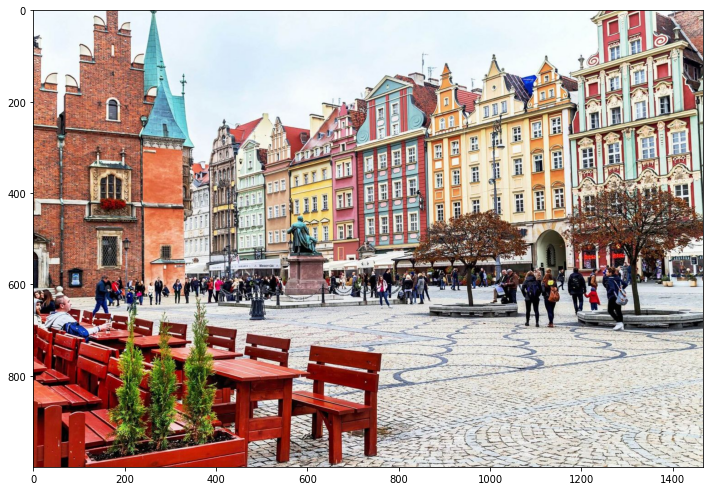

In [49]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

rynek = cv2.imread('rynek.jpg')
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(rynek[..., ::-1]);

Przykładowe rejony zainteresowania, dane jako koordynaty punktów stanowiący lewy-górny narożnik prostokąta o wymiarach 64x128:

In [7]:
# pozytywne
xy1 = (1058, 567)
xy2 = (1155, 550)
# negatywne
xyN = (656, 752)

#### Zadanie 1 (2.0 pkt | 1.0 pkt)

W tym zadaniu przećwiczysz (w niewielkim uproszczeniu) podstawową koncepcję detektora HOG. Kroki a-c powtórz dla różnych ROI, porównując wyniki.

#### Zadanie 1a (0.5 pkt | 0.0 pkt)

Wykonaj obrazy gradientów dla wybranego ROI a następnie przekształć je do postaci biegunowej. Pamiętaj o konwersji do skali szarości.

In [24]:
def get_polar_grad(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    return cv2.cartToPolar(gx, gy, angleInDegrees=True)

#### Zadanie 1b (1.0 pkt | 0.5 pkt)

Wykorzystując podany fragment do iteracji po "komórkach" obrazu, znajdź dominujący kierunek gradientu w każdej komórce. Możesz, ale nie musisz stosować finezyjnej interpolacji w zgodzie z literaturą.

In [8]:
def get_cell(image:np.ndarray, cx:int, cy:int):
    return image[cy*8:cy*8+8, cx*8:cx*8+8]

In [55]:
img = rynek
def dominating_angle(image):
    dominating = np.zeros((image.shape[0] // 8, image.shape[1] // 8))
    for y in range(0, image.shape[0] // 8):
        for x in range(0, image.shape[1] // 8):
            cell = get_cell(image, x, y)
            mag, angle = get_polar_grad(cell)
            hist = np.histogram(angle, weights=mag, bins=18, range=(0., 360.))
            m = np.argmax(hist[0])
            dominating[y, x] = (hist[1][m + 1] + hist[1][m]) / 2
    return dominating

#### Zadanie 1c (0.5 pkt | 0.5pkt)

Poniższy snippet rysuje linię o podanym kierunku w podanej komórce. Utwórz za jego pomocą wykres dominujących kierunków na przestrzeni obrazu. Tip: skonwertuj obraz do skali szarości i rysuj linie jaskrawym kolorem dla lepszej widoczności.

In [27]:
def draw_orientation(cell, angle, color):
    d = 3.5
    lca = d * np.cos(np.radians(angle))
    lsa = d * np.sin(np.radians(angle))
    p1 = int(3 - lca), int(3 - lsa)
    p2 = int(3 + lca), int(3 + lsa)
    cv2.line(cell, p1, p2, color=color, thickness=1)
    return cell

In [57]:
def get_orintation(image):
    angles = dominating_angle(image)
    image = copy(image)
    for y in range(0, image.shape[0] // 8):
        for x in range(0, image.shape[1] // 8):
            cell = get_cell(image, x, y)
            draw_orientation(cell, angles[y, x], (0, 0, 255))
    plt.subplots(1, 1, figsize=(24, 24))[1].imshow(image[..., ::-1]);

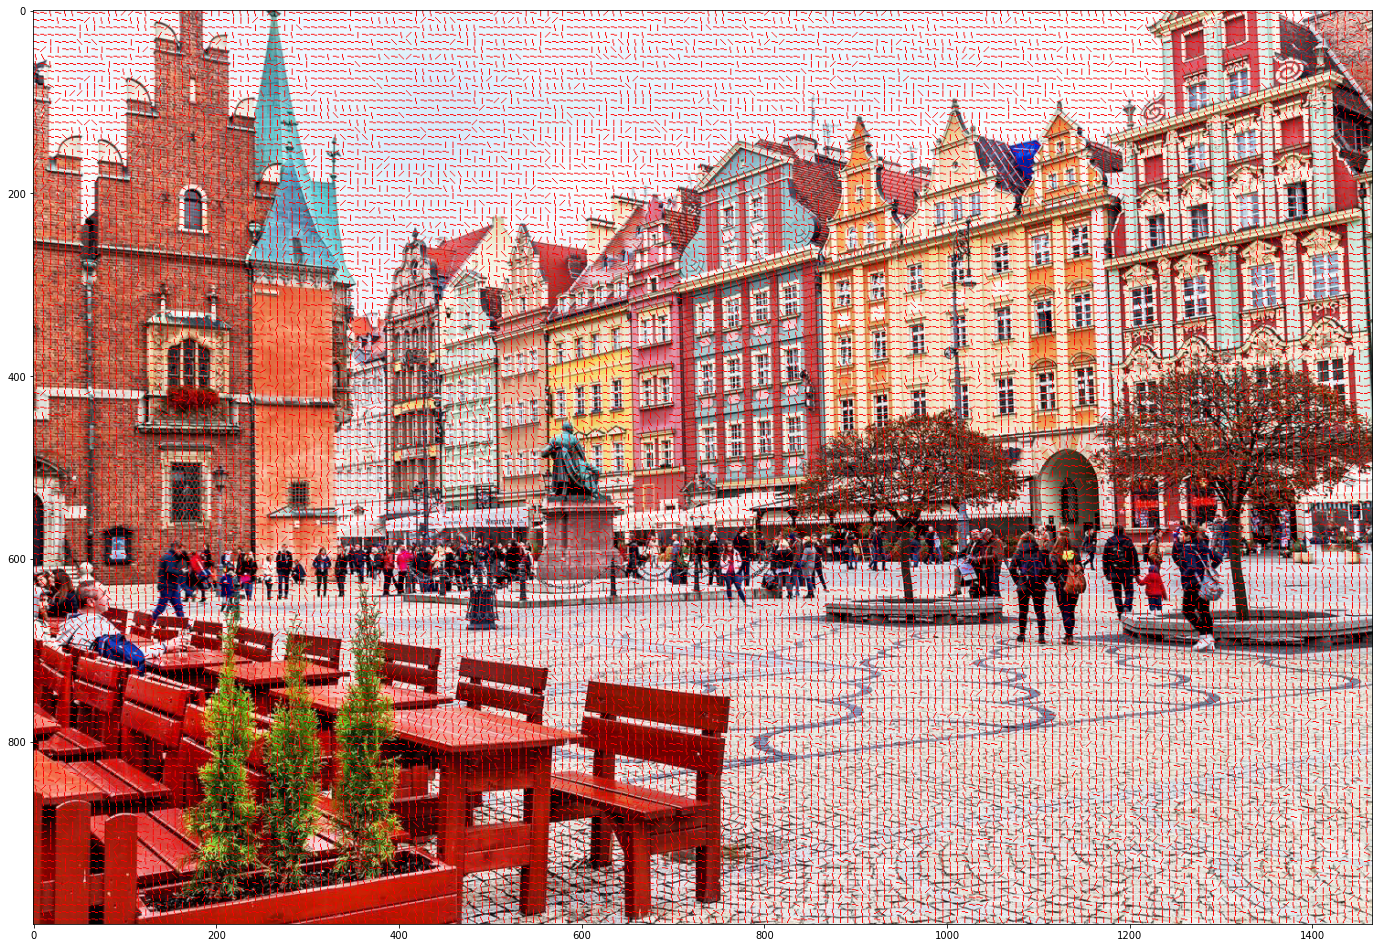

In [58]:
get_orintation(rynek)

---

#### Zadanie 2 (1.0 pkt | 1.0 pkt)

Przetestuj implementację **detektora** HOG z OpenCV na dołączonych obrazach (`rynek` i `ulica`). Domyślny konstruktor [cv2.HOGDetector](https://docs.opencv.org/4.x/d5/d33/structcv_1_1HOGDescriptor.html#a5c8e8ce0578512fe80493ed3ed88ca83) tworzy detektor wg parametryzacji z oryginalnej publikacji - pozostań przy tych wartościach.

Pamiętaj, że detektor HOG integruje deskryptor (metoda [`compute`](https://docs.opencv.org/4.x/d5/d33/structcv_1_1HOGDescriptor.html#a38cd712cd5a6d9ed0344731fcd121e8b)) oraz bazujący na podejściu sliding-window i klasyfikatorze SVM detektor (metoda [`detect`](https://docs.opencv.org/4.x/d5/d33/structcv_1_1HOGDescriptor.html#a5851df61c5b95391533144c078403672) i podobne).

Aby uzyskać podstawowy detektor wstępnie nauczony detekcji sylwetek, możesz uzyskać domyślne parametry klasyfikatora za pomocą funkcji [`cv2.HOGDescriptor_getDefaultPeopleDetector`](https://docs.opencv.org/4.x/d5/d33/structcv_1_1HOGDescriptor.html#a9c7a0b2aa72cf39b4b32b3eddea78203) i załadować je do instancji HOGa za pomocą metody [`setSVMDetector`](https://docs.opencv.org/4.x/d5/d33/structcv_1_1HOGDescriptor.html#a6de5ac55631eed51e36278cde3a2c159).

Pytania: *skąd się biorą fałszywe pozytywy?*, *jaki jest wpływ skali?*

Jeśli starczy czasu: zapoznaj się i przetestuj metodę [`detectMultiScale`](https://docs.opencv.org/4.x/d5/d33/structcv_1_1HOGDescriptor.html#a91e56a2c317392e50fbaa2f5dc78d30b).

In [10]:
ulica = cv2.imread('ulica.jpg')